### Análisis comparativo de modelos de aprendizaje automático para la
### predicción de ingresos superiores a USD 50000 en adultos utilizando
### datos del censo de 1994

El conjunto de datos consta de 15 atributos

In [56]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import svm
from sklearn import tree
from sklearn.preprocessing import scale
from sklearn.model_selection import learning_curve
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
data = pd.read_csv("adult.csv")

In [57]:
#Verificamos el tamaño del conjunto de datos
#tenemos 32561 filas y 15 columnas
data.shape 

(32561, 15)

In [58]:
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## Para los valores perdidos utilizaremos la moda para reemplazarlos
Realizamos un conteo de los atributos

In [59]:
data.count()

age               32561
workclass         32561
fnlwgt            32561
education         32561
education.num     32561
marital.status    32561
occupation        32561
relationship      32561
race              32561
sex               32561
capital.gain      32561
capital.loss      32561
hours.per.week    32561
native.country    32561
income            32561
dtype: int64

In [60]:
#Analizamos la varianza del conjunto de datos
np.var(data)

age               1.860557e+02
fnlwgt            1.114046e+10
education.num     6.618687e+00
capital.gain      5.454086e+07
capital.loss      1.623720e+05
hours.per.week    1.524543e+02
dtype: float64

# Limpieza de datos incompletos
- Calculamos la moda
- El valor de la moda se reemplaza los valores faltantes

In [61]:
data_temp=data
workclass_moda=data_temp["workclass"].mode()[0]
data_temp.loc[data_temp["workclass"]=="?","workclass"] = workclass_moda
print("La moda del atributo workclass es: ", workclass_moda)

occupation_moda=data_temp["occupation"].mode()[0]
data_temp.loc[data_temp["occupation"]=="?","occupation"] = occupation_moda
print("La moda del atributo occupation es: ", occupation_moda)

native_country_moda=data_temp["native.country"].mode()[0]
data_temp.loc[data_temp["native.country"]=="?","native.country"] = native_country_moda
print("La moda del atributo native.country es: ", native_country_moda)

data_temp.head()

La moda del atributo workclass es:  Private
La moda del atributo occupation es:  Prof-specialty
La moda del atributo native.country es:  United-States


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,Private,77053,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,Private,186061,Some-college,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [62]:
#verificamos que todos los datos esten completos
data_temp.shape

(32561, 15)

In [63]:
#Al conjunto de datos completo le llamammos data_limpia
data_limpia=data_temp

# Exploracion de datos
### Analizamos la clase income

In [64]:
#Mostramos la clase income
data_limpia["income"].value_counts()

<=50K    24720
>50K      7841
Name: income, dtype: int64

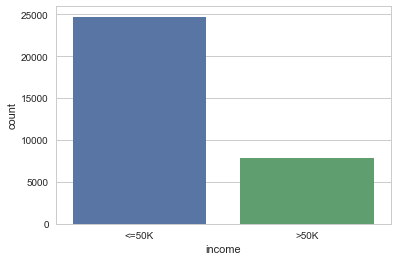

In [65]:
sns.countplot(x=data_limpia["income"] )
plt.show()

In [66]:
#Expresamos el conteo en porcentaje, para analizar su balanceo
porcentace_clase=data_limpia.income.value_counts()/len(data_limpia.income)*100
print("La clase tiene porcentajes de: ", "\n", porcentace_clase)

La clase tiene porcentajes de:  
 <=50K    75.919044
>50K     24.080956
Name: income, dtype: float64


In [67]:
#Calculo de la media de income con los atributos numericos
#se observa que capital.gain y capital.loss tienen mucha diferencia, en menor medida la age(edad) y horas
#por semana (hours.per.week)
data_limpia.groupby(data_limpia["income"]).mean()


,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
income,,,,,,
<=50K,36.783738,190340.86517,9.595065,148.752468,53.142921,38.840210
>50K,44.249841,188005.00000,11.611657,4006.142456,195.001530,45.473026


In [68]:
#revisamos los valores unicos en capital.gain
#Son pocos valores unicos y se encuentran en forma descendiente

data_limpia["capital.gain"].unique()


array([    0, 99999, 41310, 34095, 27828, 25236, 25124, 22040, 20051,
       18481, 15831, 15024, 15020, 14344, 14084, 13550, 11678, 10605,
       10566, 10520,  9562,  9386,  8614,  7978,  7896,  7688,  7443,
        7430,  7298,  6849,  6767,  6723,  6514,  6497,  6418,  6360,
        6097,  5721,  5556,  5455,  5178,  5060,  5013,  4934,  4931,
        4865,  4787,  4687,  4650,  4508,  4416,  4386,  4101,  4064,
        3942,  3908,  3887,  3818,  3781,  3674,  3471,  3464,  3456,
        3432,  3418,  3411,  3325,  3273,  3137,  3103,  2993,  2977,
        2964,  2961,  2936,  2907,  2885,  2829,  2653,  2635,  2597,
        2580,  2538,  2463,  2414,  2407,  2387,  2354,  2346,  2329,
        2290,  2228,  2202,  2176,  2174,  2105,  2062,  2050,  2036,
        2009,  1848,  1831,  1797,  1639,  1506,  1471,  1455,  1424,
        1409,  1173,  1151,  1111,  1086,  1055,   991,   914,   594,
         401,   114], dtype=int64)

In [69]:
#revisamos los valores unicos en capital.gain
#Son pocos valores unicos y se encuentran en forma descendiente

data_limpia["capital.loss"].unique()


array([4356, 3900, 3770, 3683, 3004, 2824, 2754, 2603, 2559, 2547, 2489,
       2472, 2467, 2457, 2444, 2415, 2392, 2377, 2352, 2339, 2282, 2267,
       2258, 2246, 2238, 2231, 2206, 2205, 2201, 2179, 2174, 2163, 2149,
       2129, 2080, 2057, 2051, 2042, 2002, 2001, 1980, 1977, 1974, 1944,
       1902, 1887, 1876, 1848, 1844, 1825, 1816, 1762, 1755, 1741, 1740,
       1735, 1726, 1721, 1719, 1672, 1669, 1668, 1651, 1648, 1628, 1617,
       1602, 1594, 1590, 1579, 1573, 1564, 1539, 1504, 1485, 1411, 1408,
       1380, 1340, 1258, 1138, 1092,  974,  880,  810,  653,  625,  419,
        323,  213,  155,    0], dtype=int64)

## Exploramos los atributos categoricos, respecto a los numericos, se puede realizar uno por uno

In [70]:
data_limpia.groupby("workclass").mean()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
workclass,,,,,,
Federal-gov,42.590625,185221.243750,10.973958,833.232292,112.268750,41.379167
Local-gov,41.751075,188639.712852,11.042045,880.202580,109.854276,40.982800
Never-worked,20.571429,225989.571429,7.428571,0.000000,0.000000,28.428571
Private,37.109123,192446.206791,9.833361,868.081037,78.568156,39.642345
Self-emp-inc,46.017025,175981.344086,11.137097,4875.693548,155.138889,48.818100
Self-emp-not-inc,44.969697,175608.641480,10.226289,1886.061787,116.631641,44.421881
State-gov,39.436055,184136.613251,11.375963,701.699538,83.256549,39.031587
Without-pay,47.785714,174267.500000,9.071429,487.857143,0.000000,32.714286


In [71]:
data_limpia.groupby("education").mean()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
education,,,,,,
10th,37.429796,196832.465166,6.0,404.574491,56.845659,37.052519
11th,32.355745,194928.077447,7.0,215.097872,50.079149,33.925957
12th,32.000000,199097.508083,8.0,284.087760,32.337182,35.780600
1st-4th,46.142857,239303.000000,2.0,125.875000,48.327381,38.255952
5th-6th,42.885886,232448.333333,3.0,176.021021,68.252252,38.897898
7th-8th,48.445820,188079.171827,4.0,233.939628,65.668731,39.366873
9th,41.060311,202485.066148,5.0,342.089494,28.998054,38.044747
Assoc-acdm,37.381443,193424.093721,12.0,640.399250,93.418932,40.504217
Assoc-voc,38.553546,181936.016643,11.0,715.051375,72.754703,41.610709


In [72]:
data_limpia.groupby("marital.status").mean()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
marital.status,,,,,,
Divorced,43.041639,185802.790457,10.030385,728.414810,64.600720,41.246680
Married-AF-spouse,32.478261,188165.565217,10.173913,432.652174,0.000000,41.130435
Married-civ-spouse,43.247596,186763.172877,10.320646,1764.859509,122.439103,43.284856
Married-spouse-absent,40.578947,193141.760766,9.308612,653.983254,57.779904,39.669856
Never-married,28.150988,195383.308996,9.962464,376.588318,52.345502,36.939998
Separated,39.354146,206444.325854,9.293659,535.568780,58.110244,39.301463
Widowed,58.975831,174159.042296,9.093656,571.071501,79.666667,32.979859


In [73]:
data_limpia.groupby("occupation").mean()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
occupation,,,,,,
Adm-clerical,36.964456,192043.396286,10.113528,495.954907,60.794430,37.558355
Armed-Forces,30.222222,215425.888889,10.111111,0.000000,209.666667,40.666667
Craft-repair,39.031471,192132.599658,9.110759,649.512808,88.465235,42.304221
Exec-managerial,42.169208,184414.012543,11.449090,2262.772996,138.838416,44.987703
Farming-fishing,41.211268,170190.176056,8.608652,589.726358,63.075453,46.989940
Handlers-cleaners,32.165693,204391.006569,8.510219,257.572993,45.635766,37.947445
Machine-op-inspct,37.715285,195040.877622,8.487512,328.689311,61.706294,40.755744
Other-service,34.949621,188608.452200,8.779666,191.301669,38.250683,34.701669
Priv-house-serv,41.724832,201107.523490,7.362416,279.852349,21.449664,32.885906


In [74]:
data_limpia.groupby("relationship").mean()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
relationship,,,,,,
Husband,43.818616,187074.862503,10.326461,1795.062230,124.160919,44.120139
Not-in-family,38.346057,191131.795304,10.315593,743.327273,75.390728,40.595665
Other-relative,33.164118,205059.821611,8.786952,279.595311,51.332314,37.006116
Own-child,24.827940,193175.408840,9.486188,155.655485,39.511839,33.269337
Unmarried,40.293964,191128.405688,9.642194,455.031050,41.464887,39.103018
Wife,39.846301,181849.507653,10.463010,1659.791454,118.006378,36.861607


In [75]:
data_limpia.groupby("race").mean()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
race,,,,,,
Amer-Indian-Eskimo,37.173633,120831.147910,9.311897,625.266881,34.176849,40.048232
Asian-Pac-Islander,37.746872,159940.609240,10.960539,1478.358037,97.222329,40.127045
Black,37.767926,228013.124200,9.486236,609.940461,60.385083,38.422855
Other,33.457565,197124.191882,8.841328,934.660517,61.070111,39.468635
White,38.769881,187298.064280,10.135246,1121.660375,90.806155,40.689100


In [76]:
data_limpia.groupby("sex").mean()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
sex,,,,,,
Female,36.858230,185746.311206,10.035744,568.410547,61.187633,36.410361
Male,39.433547,191771.449013,10.102891,1329.370078,100.213309,42.428086


In [77]:
data_limpia.groupby("native.country").mean()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
native.country,,,,,,
Cambodia,37.789474,193080.368421,8.789474,1027.842105,183.052632,40.894737
Canada,42.545455,179852.933884,10.652893,1504.132231,129.933884,40.404959
China,42.533333,179047.986667,11.120000,366.480000,179.520000,37.786667
Columbia,39.711864,225149.406780,9.372881,180.610169,27.152542,39.067797
Cuba,45.768421,246291.347368,9.600000,367.231579,70.042105,39.157895
Dominican-Republic,37.728571,192089.557143,7.114286,1476.057143,25.171429,42.471429
Ecuador,36.642857,185858.821429,9.464286,527.607143,0.000000,39.571429
El-Salvador,34.132075,254392.971698,6.839623,574.320755,31.113208,36.792453
England,41.155556,182375.166667,11.011111,864.722222,82.755556,41.833333


In [78]:
#calculamos la autocorrelacion
data_limpia.corr()
#Sin considerar a income, solo los datos numericos
#Se observa que age, fnlwgt, education.num, capital.gain, capital.loss y hours.per.week tienen baja correlacion.

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768
education.num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123
capital.gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409
capital.loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256
hours.per.week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000


# Visualizaciones

Text(0,0.5,'Income')

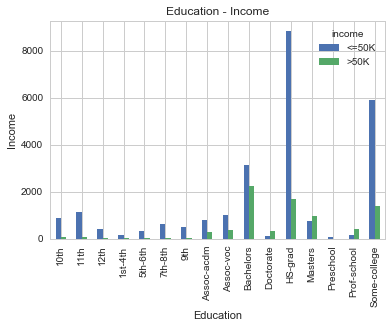

In [79]:
#Educacion vs income para ver cual afecta mas, al ser muy alta puede ser un buen predictor
pd.crosstab(data_limpia.education, data_limpia.income).plot(kind="bar")
plt.title("Education - Income")
plt.xlabel("Education")
plt.ylabel("Income")
                                                            

Text(0,0.5,'Income')

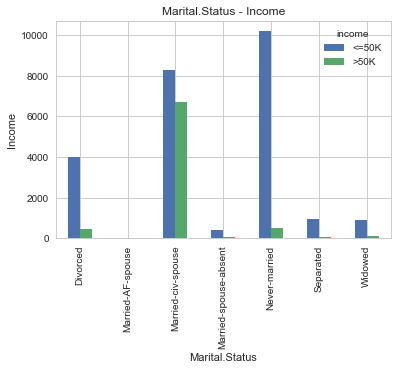

In [80]:
#Marital.statuts vs income para ver cual afecta mas
pd.crosstab(data_limpia["marital.status"] , data_limpia.income).plot(kind="bar")
plt.title("Marital.Status - Income")
plt.xlabel("Marital.Status")
plt.ylabel("Income")

Text(0,0.5,'Income')

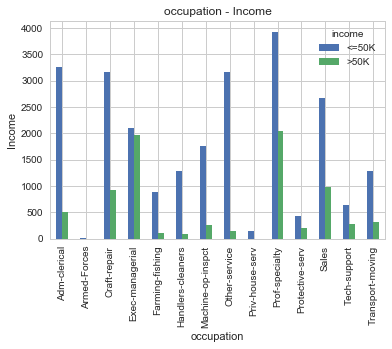

In [81]:
#Occupation vs income para ver cual afecta mas, al ser muy alta puede ser un buen predictor
pd.crosstab(data_limpia["occupation"] , data_limpia.income).plot(kind="bar")
plt.title("occupation - Income")
plt.xlabel("occupation")
plt.ylabel("Income")

Text(0,0.5,'Income')

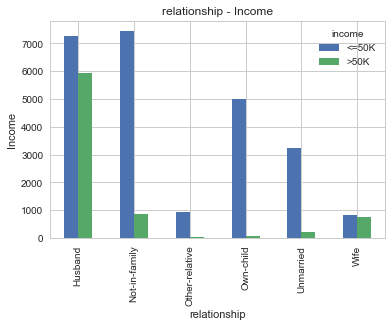

In [82]:
#relationship vs income para ver cual afecta mas, al ser muy alta puede ser un buen predictor
pd.crosstab(data_limpia["relationship"] , data_limpia.income).plot(kind="bar")
plt.title("relationship - Income")
plt.xlabel("relationship")
plt.ylabel("Income")

Text(0,0.5,'Income')

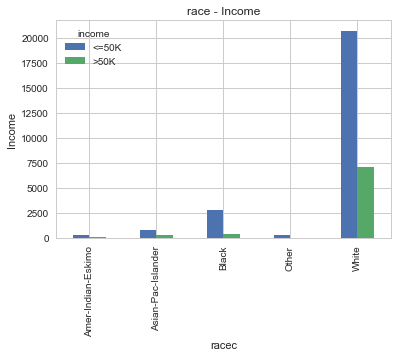

In [83]:
#race vs income para ver cual afecta mas
pd.crosstab(data_limpia["race"] , data_limpia.income).plot(kind="bar")
plt.title("race - Income")
plt.xlabel("racec")
plt.ylabel("Income")

Text(0,0.5,'Income')

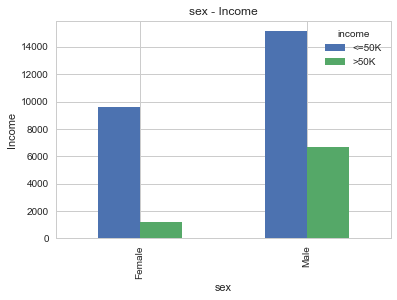

In [84]:
#sex vs income para ver cual afecta mas
pd.crosstab(data_limpia["sex"] , data_limpia.income).plot(kind="bar")
plt.title("sex - Income")
plt.xlabel("sex")
plt.ylabel("Income")

Text(0,0.5,'Income')

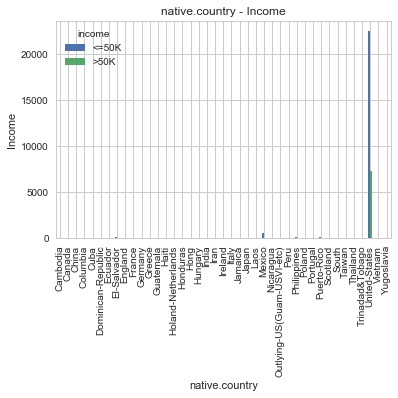

In [85]:
#Nativecountry vs income para ver cual afecta mas
pd.crosstab(data_limpia["native.country"] , data_limpia.income).plot(kind="bar")
plt.title("native.country - Income")
plt.xlabel("native.country")
plt.ylabel("Income")

## Nuevo dataset data_impia2 , sin las columnas duplicadas


In [86]:
#Creo un nueveo dataset, no utilizo education-num, relationship, cappital.gain,capital.loss
data_limpia2=data_limpia[["age", "workclass", "fnlwgt", "education", "marital.status", "occupation", "race", "sex", "hours.per.week","native.country", "income" ]]
data_limpia2.head()

,age,workclass,fnlwgt,education,marital.status,occupation,race,sex,hours.per.week,native.country,income
0,90,Private,77053,HS-grad,Widowed,Prof-specialty,White,Female,40,United-States,<=50K
1,82,Private,132870,HS-grad,Widowed,Exec-managerial,White,Female,18,United-States,<=50K
2,66,Private,186061,Some-college,Widowed,Prof-specialty,Black,Female,40,United-States,<=50K
3,54,Private,140359,7th-8th,Divorced,Machine-op-inspct,White,Female,40,United-States,<=50K
4,41,Private,264663,Some-college,Separated,Prof-specialty,White,Female,40,United-States,<=50K


# Aplico dummy, a todos los atributos menos a income

In [87]:
data_x=data_limpia2[["age", "workclass", "fnlwgt", "education", "marital.status", "occupation", "race", "sex", "hours.per.week","native.country"]]
data_x_dum=pd.get_dummies(data_x)
data_x_dum.head()

,age,fnlwgt,hours.per.week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
0,90,77053,40,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,82,132870,18,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,66,186061,40,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,54,140359,40,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,41,264663,40,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Normalizo el nuevo dataset datalimpia2
-Normalizo a data_x_dum

In [88]:
#data_norm=scale(data_limpia2[["age","fnlwgt","hours.per.week"]])
data_norm=scale(data_x_dum)
data_norm

array([[ 3.76961234, -1.06799736, -0.03542945, ...,  0.30720846,
        -0.04540836, -0.02217266],
       [ 3.18311167, -0.53916866, -1.81720429, ...,  0.30720846,
        -0.04540836, -0.02217266],
       [ 2.01011032, -0.03521956, -0.03542945, ...,  0.30720846,
        -0.04540836, -0.02217266],
       ...,
       [ 0.10398314, -0.33543266, -0.03542945, ...,  0.30720846,
        -0.04540836, -0.02217266],
       [ 1.42360965, -0.35877741, -0.03542945, ...,  0.30720846,
        -0.04540836, -0.02217266],
       [-1.21564337,  0.11095988, -1.65522476, ...,  0.30720846,
        -0.04540836, -0.02217266]])

# Divido en Train y test

In [89]:
# para los valores de x utilizo data_x_dum  que es dummis aplicado a todos menos a income
# Loa valores de y es el atributo income convertido en 1 y -1
#>50K tiene el valor de 1
#<=50K tiene el valor de -1
income_new= 2 * (data_limpia2['income'] == '>50K') - 1 

X = data_norm
y = income_new

#Balanceo la clase
#from imblearn.over_sampling import ADASYN
#ada = ADASYN(random_state=42)
#X_res, y_res = ada.fit_sample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3, stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(26048, 96)
(6513, 96)
(26048,)
(6513,)


In [90]:
y.head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: income, dtype: int32

In [91]:
#Valores de y
y.value_counts()

-1    24720
 1     7841
Name: income, dtype: int64

In [92]:
#Cantidad de valores en y_test
y_test.value_counts()

-1    4945
 1    1568
Name: income, dtype: int64

# Modelo: Regresion Logistica

In [93]:
modelo_reglog=LogisticRegression()
modelo_reglog.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Accuracy en Train

In [94]:
print("Accuracy en el conjunto train: ", modelo_reglog.score(X_train,y_train))

Accuracy en el conjunto train:  0.8324247542997543


### Accuracy en Test

In [95]:
print("Accuracy en el conjunto test: ", modelo_reglog.score(X_test,y_test))

Accuracy en el conjunto test:  0.8377091969906341


### Matriz de confusion modelo regresion logistica

In [96]:
y_pred_reglog=modelo_reglog.predict(X_test)
matriz_confusion_reglog=metrics.confusion_matrix(y_test,y_pred_reglog)
print(matriz_confusion_reglog)

[[4591  354]
 [ 703  865]]


### Calculo de la precision, recall, f-1 y support


In [97]:
print(classification_report(y_test,y_pred_reglog))

             precision    recall  f1-score   support

         -1       0.87      0.93      0.90      4945
          1       0.71      0.55      0.62      1568

avg / total       0.83      0.84      0.83      6513



### Curva ROC del modelo regresion logistica
Con un umbral a 0.5

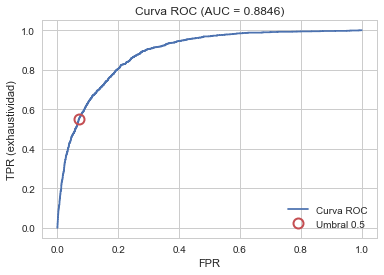

In [113]:
probabilidades_reglog_test = modelo_reglog.predict_proba(X_test)
predicciones_reglog_test = np.where(probabilidades_reglog_test[:,1] > 0.5, +1, -1) 
fpr, tpr, umbrales = metrics.roc_curve(y_test, probabilidades_reglog_test[:,1])
auc_roc = metrics.roc_auc_score(y_test, probabilidades_reglog_test[:,1])

plt.rcParams.update({'font.size': 9})
plt.plot(fpr, tpr, label= ("Curva ROC") )
plt.xlabel("FPR")
plt.ylabel("TPR (exhaustividad)")
plt.title(("Curva ROC (AUC = %.4f)" % auc_roc))
# ubicamos el punto más cercano a 0.5
umbral_05 = np.argmin(np.abs(umbrales - 0.5))
plt.plot(fpr[umbral_05], tpr[umbral_05], 'o', markersize=10,
         label="Umbral 0.5", fillstyle="none", c='r', mew=2)
plt.legend(loc='best', numpoints = 1)

### Curva de aprendizaje modelo regresion logistica

(0, 4)

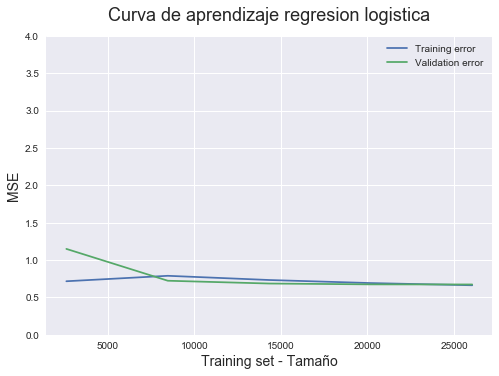

In [42]:
train_sizes_reglog, train_scores_reglog, validation_scores_reglog = learning_curve(modelo_reglog, X, y, train_sizes =  np.linspace(0.1, 1.0, 5), cv = 5, scoring = 'neg_mean_squared_error')

plt.style.use('seaborn')

train_scores_mean_reglog = -train_scores_reglog.mean(axis = 1)
validation_scores_mean_reglog = -validation_scores_reglog.mean(axis = 1)

plt.plot(train_sizes_reglog, train_scores_mean_reglog, label = 'Training error')
plt.plot(train_sizes_reglog, validation_scores_mean_reglog, label = 'Validation error')

plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set - Tamaño', fontsize = 14)
plt.title('Curva de aprendizaje regresion logistica', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,4)

### Cross validation para modelo regresion logistica
### Para evitar overfitting


Utilizando cross_val_score nos proporciona los resultados de la precisión que tuvo el modelo logreg en cada pliegue


In [43]:
precision_reglog = cross_val_score(modelo_reglog,X=X_train, y=y_train,cv=10, n_jobs=-1)

print('precisiones: {}'.format(precision_reglog))
print('Precision promedio: {0: .3f} +/- {1: .3f}'.format(np.mean(precision_reglog),
                                          np.std(precision_reglog)))

precisiones: [0.82924021 0.83077513 0.84075211 0.82034549 0.84145873 0.8421659
 0.8141321  0.83563748 0.82642089 0.8202765 ]
Precision promedio:  0.830 +/-  0.009


# Modelo: SVM

In [64]:
modelo_svm = svm.SVC()
modelo_svm.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Accuracy en Train

In [65]:
print("Accuracy en el conjunto train: ", modelo_svm.score(X_train,y_train))

Accuracy en el conjunto train:  0.8405251842751843


### Accuracy en Test

In [66]:

print("Accuracy en el conjunto test: ", modelo_svm.score(X_test,y_test))

Accuracy en el conjunto test:  0.8307999385843697


### Matriz de confusion modelo SVM


In [67]:
y_pred_svm=modelo_svm.predict(X_test)
matriz_confusion_svm=metrics.confusion_matrix(y_test,y_pred_svm)
print(matriz_confusion_svm)

[[4620  325]
 [ 777  791]]


### Calculo de la precision, recall, f-1 y support para SVM

In [68]:
print(classification_report(y_test,y_pred_svm))

             precision    recall  f1-score   support

         -1       0.86      0.93      0.89      4945
          1       0.71      0.50      0.59      1568

avg / total       0.82      0.83      0.82      6513



### Curva ROC del modelo SVM
Con un umbral a 0.5

In [69]:
probabilidades_svm_test = modelo_svm.predict(X_test)
predicciones_svm_test = np.where(probabilidades_svm_test[:,1] > 0.5, +1, -1) 
fpr, tpr, umbrales = metrics.roc_curve(y_test, probabilidades_svm_test[:,1])
auc_roc = metrics.roc_auc_score(y_test, probabilidades_svm_test[:,1])

plt.rcParams.update({'font.size': 9})
plt.plot(fpr, tpr, label= ("Curva ROC") )
plt.xlabel("FPR")
plt.ylabel("TPR (exhaustividad)")
plt.title(("Curva ROC (AUC = %.4f)" % auc_roc))
# ubicamos el punto más cercano a 0.5
umbral_05 = np.argmin(np.abs(umbrales - 0.5))
plt.plot(fpr[umbral_05], tpr[umbral_05], 'o', markersize=10,
         label="Umbral 0.5", fillstyle="none", c='r', mew=2)
plt.legend(loc='best', numpoints = 1)

IndexError: too many indices for array

### Curva de aprendizaje modelo SVM

(0, 4)

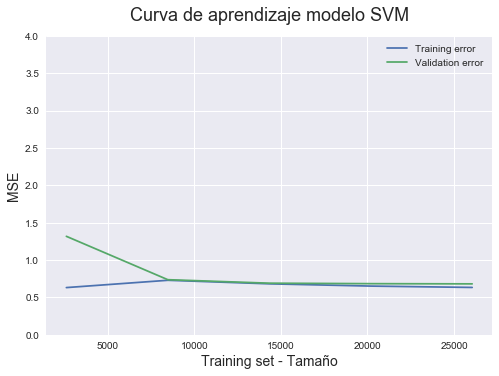

In [70]:
train_sizes_svm, train_scores_svm, validation_scores_svm = learning_curve(modelo_svm, X, y,train_sizes = np.linspace(0.1, 1.0, 5), cv = 5, scoring = 'neg_mean_squared_error')

plt.style.use('seaborn')

train_scores_mean_svm = -train_scores_svm.mean(axis = 1)
validation_scores_mean_svm = -validation_scores_svm.mean(axis = 1)

plt.plot(train_sizes_svm, train_scores_mean_svm, label = 'Training error')
plt.plot(train_sizes_svm, validation_scores_mean_svm, label = 'Validation error')

plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set - Tamaño', fontsize = 14)
plt.title('Curva de aprendizaje modelo SVM', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,4)

# Modelo: KNN

- Modelo knn con 3 vecino


In [47]:
#Modelo knn con 3 vecino
modelo_knn = KNeighborsClassifier(n_neighbors=3)
#Aplico el modelo
modelo_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

### Accuracy en Train

In [48]:
print("Accuracy en el conjunto train: ", modelo_knn.score(X_train,y_train))

Accuracy en el conjunto train:  0.8888206388206388


### Accuracy en Test

In [49]:
print("Accuracy en el conjunto train: ", modelo_knn.score(X_test,y_test))

Accuracy en el conjunto train:  0.8060801473975127


### Matriz de confusion modelo knn

In [50]:
y_pred_knn=modelo_knn.predict(X_test)
matriz_confusion_knn=metrics.confusion_matrix(y_test,y_pred_knn)
print(matriz_confusion_knn)

[[4358  587]
 [ 676  892]]


### Calculo de la precision, recall, f-1 y support

In [51]:
print(classification_report(y_test,y_pred_knn))

             precision    recall  f1-score   support

         -1       0.87      0.88      0.87      4945
          1       0.60      0.57      0.59      1568

avg / total       0.80      0.81      0.80      6513



### Curva ROC del modelo KNN
Con un umbral a 0.5

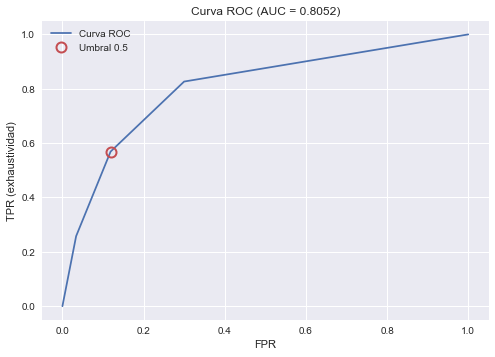

In [71]:
probabilidades_knn_test = modelo_knn.predict_proba(X_test)
predicciones_knn_test = np.where(probabilidades_knn_test[:,1] > 0.5, +1, -1) 
fpr, tpr, umbrales = metrics.roc_curve(y_test, probabilidades_knn_test[:,1])
auc_roc = metrics.roc_auc_score(y_test, probabilidades_knn_test[:,1])

plt.rcParams.update({'font.size': 9})
plt.plot(fpr, tpr, label= ("Curva ROC") )
plt.xlabel("FPR")
plt.ylabel("TPR (exhaustividad)")
plt.title(("Curva ROC (AUC = %.4f)" % auc_roc))
# ubicamos el punto más cercano a 0.5
umbral_05 = np.argmin(np.abs(umbrales - 0.5))
plt.plot(fpr[umbral_05], tpr[umbral_05], 'o', markersize=10,
         label="Umbral 0.5", fillstyle="none", c='r', mew=2)
plt.legend(loc='best', numpoints = 1)

### Curva de aprendizaje modelo KNN

(0, 4)

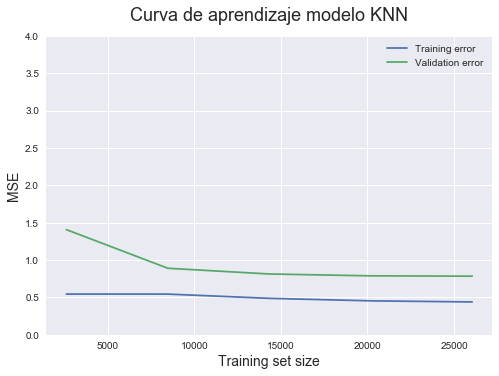

In [72]:
train_sizes_knn, train_scores_knn, validation_scores_knn = learning_curve(modelo_knn, X, y,train_sizes = np.linspace(0.1, 1.0, 5), cv = 5, scoring = 'neg_mean_squared_error')

plt.style.use('seaborn')

train_scores_mean_knn = -train_scores_knn.mean(axis = 1)
validation_scores_mean_knn = -validation_scores_knn.mean(axis = 1)

plt.plot(train_sizes_knn, train_scores_mean_knn, label = 'Training error')
plt.plot(train_sizes_knn, validation_scores_mean_knn, label = 'Validation error')

plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Curva de aprendizaje modelo KNN', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,4)

# Modelo: Arboles de clasificacion

In [52]:
#Modelo arboles de clasificacion
#Si dejo que use toda la profunidad alcanza un accuraci de 1
#Si le añado profunidad con profundidad 4
modelo_tree=tree.DecisionTreeClassifier(max_depth=15)
#Aplico el modelo
modelo_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Accuracy en Train

In [53]:
print("Accuracy en el conjunto train: ", modelo_tree.score(X_train,y_train))

Accuracy en el conjunto train:  0.8955006142506142


### Accuracy en Test

In [54]:
print("Accuracy en el conjunto test: ", modelo_tree.score(X_test,y_test))

Accuracy en el conjunto test:  0.8139106402579457


### Matriz de confusion modelo arbol de clasificacion

In [55]:
y_pred_tree=modelo_tree.predict(X_test)
matriz_confusion_tree=metrics.confusion_matrix(y_test,y_pred_tree)
print(matriz_confusion_tree)

[[4466  479]
 [ 733  835]]


### Calculo de la precision, recall, f-1 y support

In [56]:
print(classification_report(y_test,y_pred_reglog))

             precision    recall  f1-score   support

         -1       0.87      0.93      0.90      4945
          1       0.71      0.55      0.62      1568

avg / total       0.83      0.84      0.83      6513



### Curva ROC del modelo arbol de clasificacion
Con un umbral a 0.5

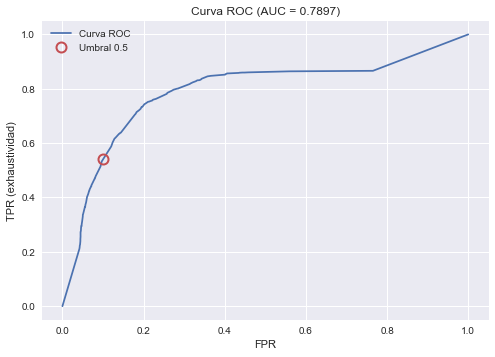

In [75]:
probabilidades_tree_test = modelo_tree.predict_proba(X_test)
predicciones_tree_test = np.where(probabilidades_tree_test[:,1] > 0.5, +1, -1) 
fpr, tpr, umbrales = metrics.roc_curve(y_test, probabilidades_tree_test[:,1])
auc_roc = metrics.roc_auc_score(y_test, probabilidades_tree_test[:,1])

plt.rcParams.update({'font.size': 9})
plt.plot(fpr, tpr, label= ("Curva ROC") )
plt.xlabel("FPR")
plt.ylabel("TPR (exhaustividad)")
plt.title(("Curva ROC (AUC = %.4f)" % auc_roc))
# ubicamos el punto más cercano a 0.5
umbral_05 = np.argmin(np.abs(umbrales - 0.5))
plt.plot(fpr[umbral_05], tpr[umbral_05], 'o', markersize=10,
         label="Umbral 0.5", fillstyle="none", c='r', mew=2)
plt.legend(loc='best', numpoints = 1)

### Curva de aprendizaje modelo arbol de clasificacion

(0, 4)

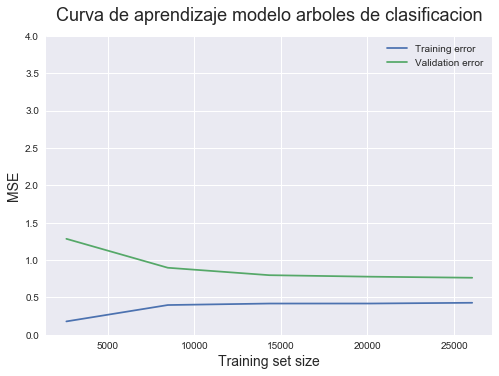

In [76]:
train_sizes_tree, train_scores_tree, validation_scores_tree = learning_curve(modelo_tree, X, y,train_sizes = np.linspace(0.1, 1.0, 5), cv = 5, scoring = 'neg_mean_squared_error')

plt.style.use('seaborn')

train_scores_mean_tree = -train_scores_tree.mean(axis = 1)
validation_scores_mean_tree = -validation_scores_tree.mean(axis = 1)

plt.plot(train_sizes_tree, train_scores_mean_tree, label = 'Training error')
plt.plot(train_sizes_tree, validation_scores_mean_tree, label = 'Validation error')

plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Curva de aprendizaje modelo arboles de clasificacion', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,4)

### Cross validation para arboles de clasificacion
Para evitar overfitting

-NOTA: cuando dejo la profundidad maxima, cross validation baja a 0.75, cuando vario la profundidad, los valores
de crossvalidation son similares a los del arbol normal

In [57]:
precision_tree = cross_val_score(modelo_tree,X=X_train, y=y_train,cv=10, n_jobs=-1)

print('precisiones: {}'.format(precision_tree))
print('Precision promedio: {0: .3f} +/- {1: .3f}'.format(np.mean(precision_tree),
                                          np.std(precision_tree)))

precisiones: [0.80506523 0.81120491 0.81696086 0.80882917 0.81266795 0.81950845
 0.79877112 0.81259601 0.80721966 0.81797235]
Precision promedio:  0.811 +/-  0.006


# Modelo: Extra tree classifier

In [58]:
#Modelo arboles de clasificacion
modelo_xtratree=tree.ExtraTreeClassifier(max_depth=15)
#APlico el modelo
modelo_xtratree.fit(X_train,y_train)

ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')

### Accuracy en Train

In [59]:
print("Accuracy en el conjunto train: ", modelo_xtratree.score(X_train,y_train))

Accuracy en el conjunto train:  0.8383753071253072


### Accuracy en Test

In [60]:
print("Accuracy en el conjunto test: ", modelo_xtratree.score(X_test,y_test))

Accuracy en el conjunto test:  0.826654383540611


### Matriz de confusion modelo extra tree classifier

In [61]:
y_pred_xtree=modelo_xtratree.predict(X_test)
matriz_confusion_xtree=metrics.confusion_matrix(y_test,y_pred_xtree)
print(matriz_confusion_xtree)

[[4596  349]
 [ 780  788]]


### Calculo de la precision, recall, f-1 y support

In [62]:
print(classification_report(y_test,y_pred_xtree))

             precision    recall  f1-score   support

         -1       0.85      0.93      0.89      4945
          1       0.69      0.50      0.58      1568

avg / total       0.82      0.83      0.82      6513



### Curva ROC del modelo extra tree classifier
Con un umbral a 0.5

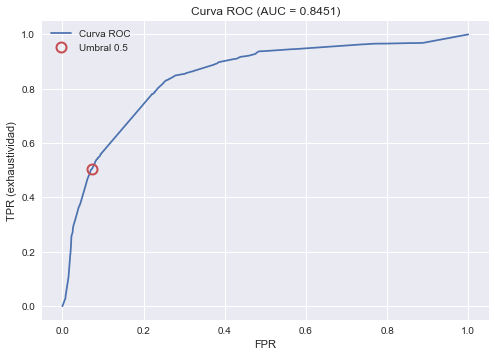

In [73]:
probabilidades_xtree_test = modelo_xtratree.predict_proba(X_test)
predicciones_xtree_test = np.where(probabilidades_xtree_test[:,1] > 0.5, +1, -1) 
fpr, tpr, umbrales = metrics.roc_curve(y_test, probabilidades_xtree_test[:,1])
auc_roc = metrics.roc_auc_score(y_test, probabilidades_xtree_test[:,1])

plt.rcParams.update({'font.size': 9})
plt.plot(fpr, tpr, label= ("Curva ROC") )
plt.xlabel("FPR")
plt.ylabel("TPR (exhaustividad)")
plt.title(("Curva ROC (AUC = %.4f)" % auc_roc))
# ubicamos el punto más cercano a 0.5
umbral_05 = np.argmin(np.abs(umbrales - 0.5))
plt.plot(fpr[umbral_05], tpr[umbral_05], 'o', markersize=10,
         label="Umbral 0.5", fillstyle="none", c='r', mew=2)
plt.legend(loc='best', numpoints = 1)

### Curva de aprendizaje modelo extra tree classfifier

(0, 4)

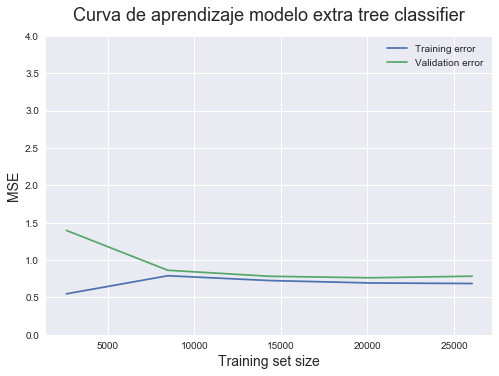

In [74]:
train_sizes_xtree, train_scores_xtree, validation_scores_xtree = learning_curve(modelo_xtratree, X, y,train_sizes = np.linspace(0.1, 1.0, 5), cv = 5, scoring = 'neg_mean_squared_error')

plt.style.use('seaborn')

train_scores_mean_xtree = -train_scores_xtree.mean(axis = 1)
validation_scores_mean_xtree = -validation_scores_xtree.mean(axis = 1)

plt.plot(train_sizes_xtree, train_scores_mean_xtree, label = 'Training error')
plt.plot(train_sizes_xtree, validation_scores_mean_xtree, label = 'Validation error')

plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Curva de aprendizaje modelo extra tree classifier', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,4)

### Cross validation para extra tree classifier

In [63]:
precision_xtree = cross_val_score(modelo_xtratree,X=X_train, y=y_train,cv=10, n_jobs=-1)

print('precisiones: {}'.format(precision_xtree))
print('Precision promedio: {0: .3f} +/- {1: .3f}'.format(np.mean(precision_xtree),
                                          np.std(precision_xtree)))

precisiones: [0.81964697 0.81465848 0.81389102 0.80153551 0.80767754 0.81259601
 0.79185868 0.81605223 0.81105991 0.80030722]
Precision promedio:  0.809 +/-  0.008


# ENSAMBLE
Mis modelos son:  logreg, modelo_svm, modelo_knn, modelo_tree y modelo_xtratree


In [77]:
pred_base_train = pd.concat([pd.DataFrame(logreg.predict(X_train)),
                             pd.DataFrame(modelo_svm.predict(X_train)),
                             pd.DataFrame(modelo_knn.predict(X_train)),
                             pd.DataFrame(modelo_tree.predict(X_train))], 
                         axis=1)
pred_base_train.head()

,0,0,0,0
0,1,1,1,1
1,-1,-1,-1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1


In [79]:
#c=1/alfa
mejor_score = 0
mejor_C = None

for C in np.logspace(-2,4,13):  # ~ [0.01, 0.03, 0.1, ..., 10000] 
    modelo_ensamble = LogisticRegression(penalty='l2', C=C, random_state=0)
    scores_val = cross_val_score(modelo_ensamble, pred_base_train, y_train, cv=10)
    score_val_medio = np.mean(scores_val)  # Obtener la exactitud media de la validación cruzada en cada fold
    if score_val_medio > mejor_score: 
        mejor_score = score_val_medio
        mejor_C = C

modelo_ensamble = LogisticRegression(penalty='l2', C=mejor_C, random_state=0)
modelo_ensamble.fit(pred_base_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [80]:
#calculo el accuracy

pred_base_test = pd.concat([pd.DataFrame(logreg.predict(X_test)),
                             pd.DataFrame(modelo_svm.predict(X_test)),
                             pd.DataFrame(modelo_knn.predict(X_test)),
                             pd.DataFrame(modelo_tree.predict(X_test))], 
                         axis=1)

In [81]:
modelo_ensamble.score(pred_base_test, y_test)

0.80009212344541691